https://www.kaggle.com/ashirahama/blending

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
sns.set_style("darkgrid")
import warnings 
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

from scipy import stats
from scipy.stats import norm,skew

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
#IDはモデルの予測に不要のため、いったん落とす
train_ID=train["Id"]
test_ID=test["Id"]

train.drop("Id",axis=1,inplace=True)
test.drop("Id",axis=1,inplace=True)

In [4]:
print("Size of train data after dropping Id :{}".format(train.shape))
print("Size of test data after dropping Id:{}".format(test.shape))

Size of train data after dropping Id :(1460, 80)
Size of test data after dropping Id:(1459, 79)


外れ値の対応

GrLivAreanの外れ値を取ることを、データ作成者が推薦しているため4000以上のものを除外する。

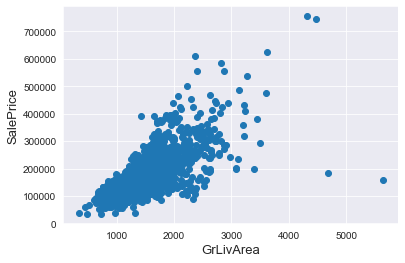

In [5]:
fig,ax=plt.subplots()
ax.scatter(x=train["GrLivArea"],y=train["SalePrice"])
plt.ylabel("SalePrice",fontsize=13)
plt.xlabel("GrLivArea",fontsize=13)
plt.show()

In [6]:
train=train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index)

相関関係の確認

相関関係が0.5以上のものを確認する

In [7]:
correlations=train.corr()["SalePrice"].sort_values()

print("Most Positive Correlations:\n",correlations.tail(30))
print("\nMost Negative Correlations:\n",correlations.head(30))

Most Positive Correlations:
 BsmtHalfBath   -0.016881
BsmtFinSF2     -0.011422
3SsnPorch       0.044568
MoSold          0.046124
PoolArea        0.099490
ScreenPorch     0.111415
BedroomAbvGr    0.168245
BsmtUnfSF       0.214460
BsmtFullBath    0.228459
LotArea         0.268179
HalfBath        0.284590
2ndFlrSF        0.320532
OpenPorchSF     0.321142
WoodDeckSF      0.324758
LotFrontage     0.370584
BsmtFinSF1      0.409384
Fireplaces      0.469862
MasVnrArea      0.482719
GarageYrBlt     0.487156
YearRemodAdd    0.507717
YearBuilt       0.523608
TotRmsAbvGrd    0.537769
FullBath        0.562165
GarageArea      0.629217
1stFlrSF        0.631530
GarageCars      0.641047
TotalBsmtSF     0.651153
GrLivArea       0.734968
OverallQual     0.795774
SalePrice       1.000000
Name: SalePrice, dtype: float64

Most Negative Correlations:
 KitchenAbvGr    -0.135946
EnclosedPorch   -0.128646
MSSubClass      -0.084276
OverallCond     -0.077948
YrSold          -0.028882
LowQualFinSF    -0.025625
Mis

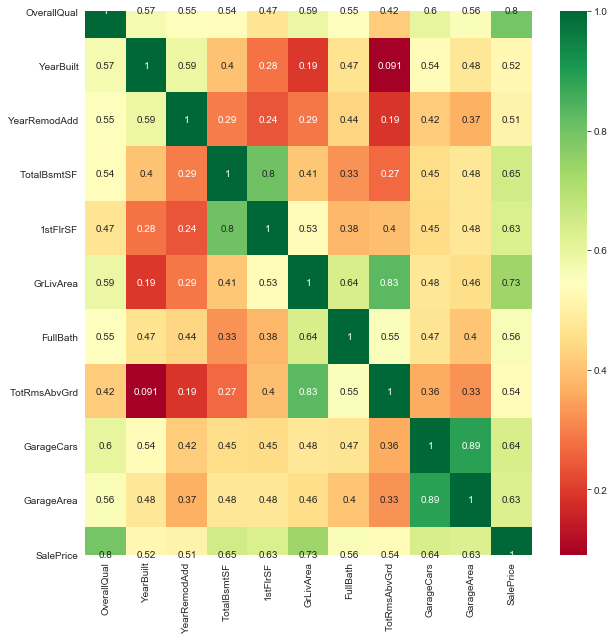

In [8]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

以下の項目とSalePriceの相関関係が強いことが分かる

OverallQual, GrLivArea, TotalBsmtSF, GarageCars, GarageArea, 1stFlrSF

上記の内GarageCarsとGarageAreaの相関が強い（まあ止められる車の数と車庫の大きさが大きいのは当たり前かな・・・・）

TotalBSMTSF（地下室の面積）と1stFlrSF（1階の面積）の相関も高い


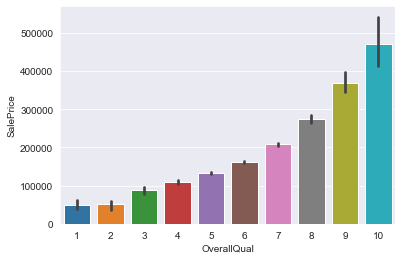

In [9]:
sns.barplot(train.OverallQual,train.SalePrice)

OverallQual（家の状態）によって価格が明らかに上昇しているのが分かる

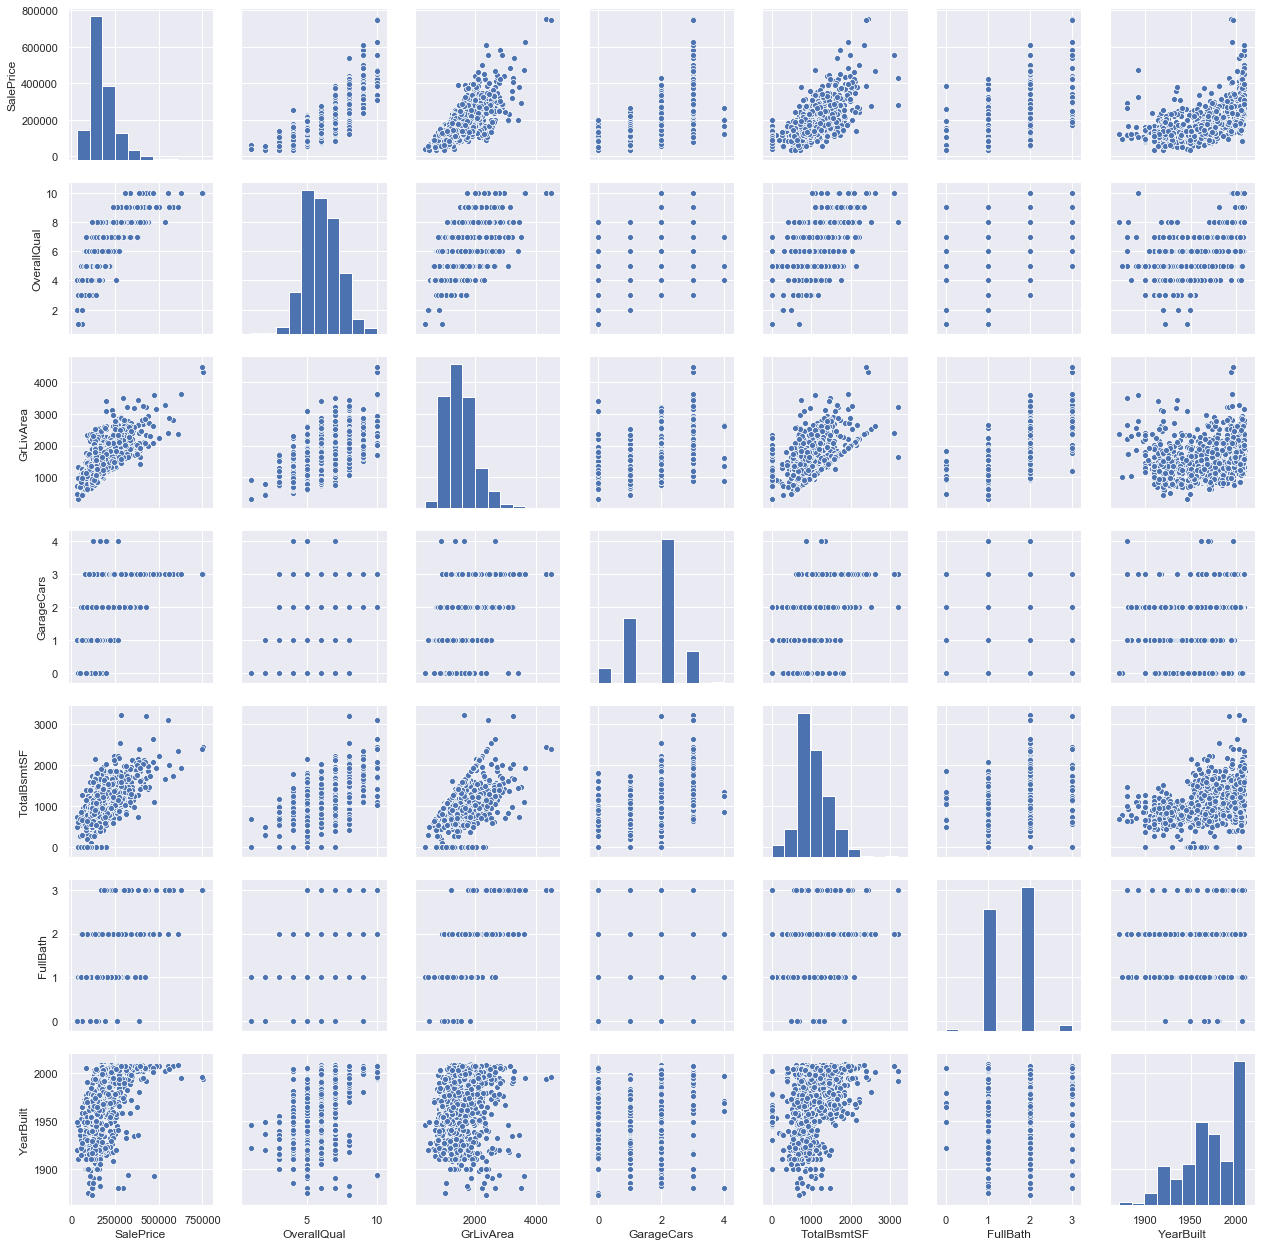

In [10]:
sns.set()
cols=["SalePrice","OverallQual","GrLivArea","GarageCars","TotalBsmtSF","FullBath","YearBuilt"]
sns.pairplot(train[cols],size=2.5)
plt.show()

散布図を見るとTotalBsmtSF（地下面積）とGrLivArea（Above ground living area square feet）の形がちょっと変なことが分かる

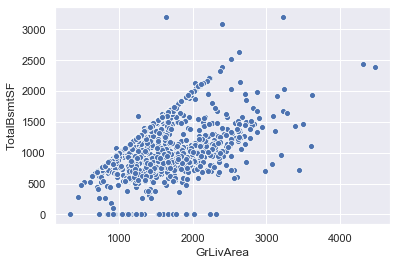

In [11]:
sns.scatterplot(train.GrLivArea,train.TotalBsmtSF)

TotalBsmtSFとGrLivAreaは同じになるケースが多く、TotalBsmtSFの値がGrLivAreaの値を来れることがまれである

もう少し詳細にSalePriceとFeatureの関係を調べる

目的変数の変形

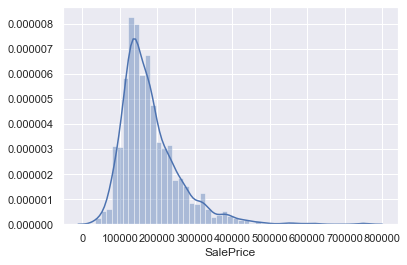

In [12]:
sns.distplot(train["SalePrice"])
plt.show()

目的変数（SalePrice）をヒストグラムに起こすと、正規分布になっていないことが分かる。そのため対数化する（値の振れ幅を小さくすることでばらつきを小さくする）

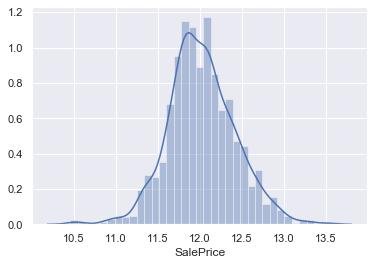

In [13]:
#対数計算を実施
#数字のばらつき、偏りを小さくする
train["SalePrice"]=np.log1p(train["SalePrice"])

sns.distplot(train["SalePrice"])
plt.show()

特徴量エンジニアリング

In [14]:
#全データを一旦結合
#テストも含めた全データで特徴量を見ていく（例：欠損値を補完する際のmedian値など）
ntrain=train.shape[0]
ntest=test.shape[0]
y_train=train.SalePrice.values
all_data=pd.concat((train,test)).reset_index(drop=True)
all_data.drop(["SalePrice"],axis=1,inplace=True)
print("all_data size is :{}".format(all_data.shape))

all_data size is :(2917, 79)


欠損値

欠損値の確認

In [15]:
#欠損値の確認
all_data_na=(all_data.isnull().sum()/len(all_data))*100
#Top30だけを一旦見る
all_data_na=all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data=pd.DataFrame({"Missing Ratio":all_data_na})

Text(0.5, 1.0, 'Percent missing data b feature')

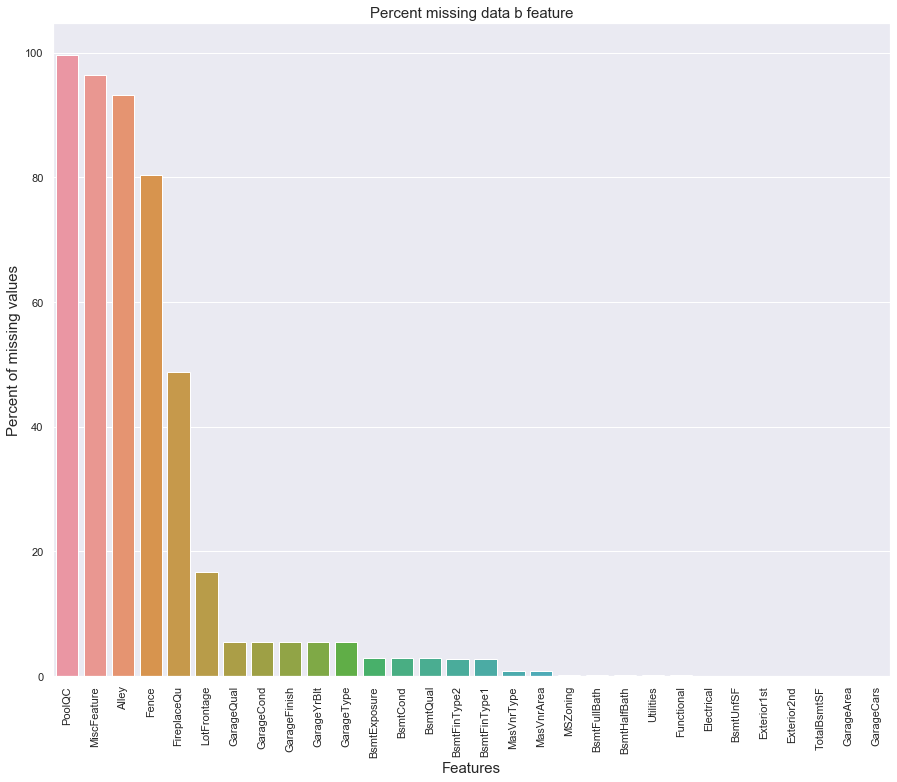

In [16]:
f,ax=plt.subplots(figsize=(15,12))
plt.xticks(rotation="90")
sns.barplot(x=all_data_na.index,y=all_data_na)
plt.xlabel("Features",fontsize=15)
plt.ylabel("Percent of missing values",fontsize=15)
plt.title("Percent missing data b feature",fontsize=15)

In [17]:
#最も欠損値の多いPool1QC(プールの品質)を見る
all_data.PoolQC.loc[all_data.PoolQC.notnull()]

197     Ex
809     Fa
1169    Gd
1181    Ex
1384    Fa
1421    Gd
1972    Ex
2571    Ex
2708    Gd
Name: PoolQC, dtype: object

In [18]:
#欠損値の補完
#PoolQCにおいてNullの部分はNo Pool（プールがない）という場合。今回はNullの部分をNoneという文字で埋める
all_data["PoolQC"]=all_data["PoolQC"].fillna("None")

In [19]:
#MiscFeature(その他の特徴)でのNullはno misc feature
all_data["MiscFeature"]=all_data["MiscFeature"].fillna("None")
all_data["Alley"]=all_data["Alley"].fillna("None")
all_data["Fence"]=all_data["Fence"].fillna("None")
all_data["FireplaceQu"]=all_data["FireplaceQu"].fillna("None")

In [20]:
grouped_df=all_data.groupby("Neighborhood")["LotFrontage"]

for key,item in grouped_df:
    print(key,"\n")
    print(grouped_df.get_group(key))
    break

Blmngtn 

219     43.0
229     43.0
385     43.0
443     53.0
465      NaN
558      NaN
596     53.0
638     53.0
789     43.0
850      NaN
981     43.0
1003    43.0
1018    43.0
1022    43.0
1125    53.0
1392    53.0
1413    51.0
1481    43.0
1683    43.0
1982     NaN
1983     NaN
1984    53.0
2318     NaN
2319    53.0
2669    43.0
2670     NaN
2671     NaN
2672    43.0
Name: LotFrontage, dtype: float64


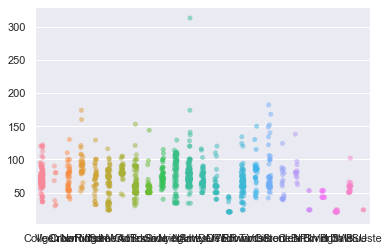

In [21]:
sns.stripplot(x=train.Neighborhood.values,y=train.LotFrontage.values,jitter=0.1,alpha=0.5)

In [22]:
all_data["LotFrontage"]=all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [23]:
for col in ["GarageType","GarageFinish","GarageQual","GarageCond"]:
    all_data[col]=all_data[col].fillna("None")

In [24]:
abc=['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt', 'GarageArea', 'GarageCars']
all_data.groupby("GarageType")[abc].count()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageArea,GarageCars
GarageType,,,,,,,
2Types,23,23,23,23,23,23,23
Attchd,1722,1722,1722,1722,1722,1722,1722
Basment,36,36,36,36,36,36,36
BuiltIn,185,185,185,185,185,185,185
CarPort,15,15,15,15,15,15,15
Detchd,779,779,779,779,777,778,778
None,157,157,157,157,0,157,157


In [25]:
for col in ("GarageYrBlt","GarageArea","GarageCars"):
    all_data[col]=all_data[col].fillna(0)

In [26]:
for col in ("BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF","TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"):
    all_data[col]=all_data[col].fillna(0)

In [27]:
for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
    all_data[col]=all_data[col].fillna("None")

In [28]:
all_data["MasVnrType"]=all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"]=all_data["MasVnrArea"].fillna(0)

In [29]:
all_data["MSZoning"].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [30]:
all_data=all_data.drop(["Utilities"],axis=1)

In [31]:
all_data["Functional"]=all_data["Functional"].fillna("Typ")

In [32]:
mode_col=['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data[col]=all_data[col].fillna(all_data[col].mode()[0])

In [33]:
all_data["MSSubClass"]=all_data["MSSubClass"].fillna("None")

In [34]:
#欠損値がないか確認
all_data_na=(all_data.isnull().sum()/len(all_data))*100
all_data_na=all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
missing_data=pd.DataFrame({"Missing Ratio":all_data_na})
missing_data.head()

,Missing Ratio
MSZoning,0.137127


In [35]:
#数値型のカテゴリー値の対応
#数値型のカテゴリーをきちんとカテゴリー型に変換しない場合、モデルによっては数値の大小関係を判断してしまう。ちゃんと変換が必要
all_data["OverallCond"].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

In [36]:

all_data["MSSubClass"]=all_data["MSSubClass"].apply(str)

all_data["OverallCond"]=all_data["OverallCond"].astype(str)

all_data["YrSold"]=all_data["YrSold"].astype(str)
all_data["MoSold"]=all_data["MoSold"].astype(str)

In [37]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl=LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c]=lbl.transform(list(all_data[c].values))
    
print("Shape all_data:{}".format(all_data.shape))

Shape all_data:(2917, 78)


In [38]:
all_data["TotalSF"]=all_data["TotalBsmtSF"]+all_data["1stFlrSF"]+all_data["2ndFlrSF"]
#相関の強い２つを掛け合わせる
all_data["Interaction"]=all_data["TotalSF"]*all_data["OverallQual"]

In [39]:
numeric_feats=all_data.dtypes[all_data.dtypes!="object"].index

skewed_feats=all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numercical features:\n")
skewness=pd.DataFrame({"Skew":skewed_feats})
skewness.head(15)


Skew in numercical features:



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [40]:
skewness=skewness[abs(skewness)>0.75]
print("There are {} skewed numerical features to box cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features=skewness.index
lam=0.15
for feat in skewed_features:
    all_data[feat]=boxcox1p(all_data[feat],lam)

There are 60 skewed numerical features to box cox transform


Dummy-Encoding

カテゴリー型の値をone-hotencodingで変換する

In [41]:
all_data=pd.get_dummies(all_data)
all_data.shape

(2917, 221)

モデルの作成

Importing Libraries

We will use models

Lasso

Ridge

ElasticNet

Gradient Boosting

XGBoosting

LightGBM

相互検証スコアを見つけます。

すべてのモデルの予測の平均を計算します。

CSVファイルを送信します。

In [42]:
train=all_data[:ntrain]
test=all_data[ntrain:]
train.shape

(1458, 221)

In [43]:
from sklearn.linear_model import ElasticNet,Lasso,BayesianRidge,LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [44]:
#クロスバリデーション用の関数
n_folds=5

def rmsle_cv(model):
    kf=KFold(n_folds,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse=np.sqrt(-cross_val_score(model,train.values,y_train,scoring="neg_mean_squared_error",cv=kf))
    return(rmse)

In [45]:
#Ridge Regression
KRR=KernelRidge(alpha=0.6,kernel="polynomial",degree=2,coef0=2.5)
score=rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f}({:.4f})\n".format(score.mean(),score.std()))

Kernel Ridge score: 0.1158(0.0081)



In [46]:
#Lasso Regression
lasso=make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=1))
score=rmsle_cv(lasso)
print("Lasso score:{:.4f}({:.4f})\n".format(score.mean(),score.std()))

Lasso score:0.1114(0.0073)



In [47]:
#Elastic Net Regression
ENet=make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005,l1_ratio=.9,random_state=3))
score=rmsle_cv(ENet)
print("ElasticNet score {:.4f}({:.4f})\n".format(score.mean(),score.std()))

ElasticNet score 0.1114(0.0074)



In [49]:
GBoost=GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,
                                max_depth=4,max_features="sqrt",
                                min_samples_leaf=15,min_samples_split=10,
                                loss="huber",random_state=5)
score=rmsle_cv(GBoost)
print("Xgboost score:{:.4f}({:.4f})\n".format(score.mean(),score.std()))

Xgboost score:0.1169(0.0061)



In [52]:
model_xgb=xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score=rmsle_cv(model_xgb)
print("Xgboost score:{:.4f}({:.4f})\n".format(score.mean(),score.std()))

Xgboost score:0.1169(0.0067)



In [53]:
#LightGBM
model_lgb=lgb.LGBMRegressor(objective="regression",num_leaves=5,learning_rate=0.05,
                           n_estimators=720,max_bin=55,bagging_fraction=0.8,
                           bagging_freq=5,feature_fraction=0.2319,feature_fraction_seed=9,
                           bagging_seed=9,min_data_in_leaf=6,min_sum_hessian_in_leaf=11)
score=rmsle_cv(model_lgb)
print("LGBM score:{:.4f}({:.4f})\n".format(score.mean(),score.std()))

LGBM score:0.1155(0.0058)



In [56]:
LassoMd=lasso.fit(train.values,y_train)
ENetMd=ENet.fit(train.values,y_train)
KRRMd=KRR.fit(train.values,y_train)
GBoostMd=GBoost.fit(train.values,y_train)
XGBMd=model_xgb.fit(train.values,y_train)
LGBMd=model_lgb.fit(train.values,y_train)

In [57]:
finalMd = (np.expm1(LassoMd.predict(test.values)) + np.expm1(ENetMd.predict(test.values)) + np.expm1(KRRMd.predict(test.values)) + np.expm1(GBoostMd.predict(test.values))  + np.expm1(XGBMd.predict(test.values))  + np.expm1(LGBMd.predict(test.values)) ) / 6
finalMd

array([121540.08518978, 162321.54288379, 186144.34986227, ...,
       167124.83992175, 114175.11094844, 221434.46616936])